In [4]:
# MobileNet_v2

"""
[Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""

from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, add, Reshape
from keras.applications.mobilenet import relu6, DepthwiseConv2D
from keras.utils import plot_model

from keras import backend as K

def _conv_block(inputs, filters, kernel, strides):
    """
    :param inputs: Tensor, input tensor of convolution layer 
    :param filters: Integer, the depth of output
    :param kernel:  An integer or tuple/list of 2 integers, kernel's width and height 
    :param strides: An integer of tuple/list of 2 integers, strides along width and height
    :return: Output tensor
    """
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)
    
    return x

def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """
    defines the basic bottleneck structure
    
    :param inputs: Tensor, input tensor of convolution layer
    :param filters: Integer, the depth of output space 
    :param kernel: An integer or tuple/list of 2 integers, kernel's width and height
    :param t: Integer, expansion factor, always apply to the input size
    :param s: An integer or tuple/list of 2 integers, strides along width and height
    :param r: Boolean, whether to use the residuals
    :return: Output tensor
    """
    
    channel_axis = 1 if K.image_data_format() == 'channel_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)
    
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    
    
    if r:
        x = add([x, inputs])
        
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """
    Inverted Residual Block
    
    :param inputs: Tensor, input tensor of convolution layer
    :param filters: Integer, the depth of the output space
    :param kernel: An integer or tuple/list of 2 integers, kernel's width and height
    :param t: Integer, expansion factor, always applied to the input size
    :param strides: An integer or tuple/list of 2 integers, strides along width and height
    :param n: Integer, layer repeat times
    :return: Output tensor
    """
    
    x = _bottleneck(inputs, filters, kernel, t, strides)
    
    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)
        
    return x

def MobileNetv2(input_shape, k):
    """
    MobileNetv2 architectures
    
    :param input_shape: An integer or tuple/list of 3 integers, shape of input tensor 
    :param k: Integer, number of classes
    :return: MobileNetv2 model
    """
    
    inputs = Input(shape=input_shape)
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))
    
    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)
    
    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    
    x = Activation('softmax', name='softmax')(x)
    
    output = Reshape((k, ))(x)
    
    model = Model(inputs, output)
    
    return model

# if __name__ == '__main__':
#     MobileNetv2((224, 224, 3), 100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 112, 112, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 112, 112, 32) 128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 112, 112, 32) 0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

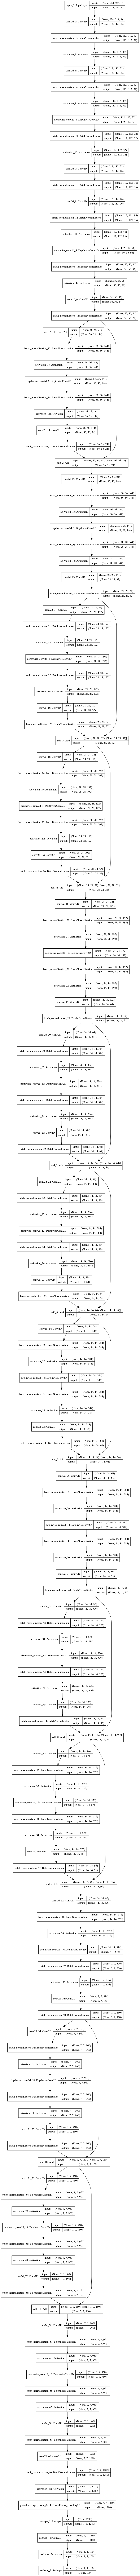

In [5]:
from IPython.display import Image

model = MobileNetv2((224, 224, 3), 100)

model.summary()
plot_model(model, to_file='MobileNetv2.png', show_shapes=True)
Image('MobileNetv2.png')